In [166]:
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle
import sys

sys.path.append("../code/python/utils")
from pool_iterator import pool_iterator
from metric import calculate_metric
from json_tools import get_from_pool
sys.path.append("../code/python/bandits")
from tomson_bandit import TomsonBandit
from cascade_bandit import CascadeBandit, get_nearest_queries
from damerau_levenshtien import damerau_levenshtein_distance

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
n_objects = 569105

In [3]:
queries_counter = pickle.load(open("queries_counter", "rb"))
queries_by_word = pickle.load(open("queries_by_word", "rb"))

In [4]:
%%time
position_variants = list(range(10)) + [100]
bandits_by_queries = {
    query: TomsonBandit(position_variants) for query in queries_counter
}
big_bandit = CascadeBandit(bandits_by_queries, queries_by_word)

CPU times: user 4.86 s, sys: 139 ms, total: 5 s
Wall time: 5 s


In [119]:
queries = iter(queries_counter.keys())

In [141]:
def get_query(i):
    queries = iter(queries_counter.keys())
    for _ in range(i):
        query = next(queries)
    return query

In [149]:
q1 = get_query(1)
q2 = get_query(4)
q1, q2

((0, 1, 2, 3), (11, 12))

In [165]:
q1 = (0, 1, 2, 3)
q2 = (2, 1)

In [167]:
damerau_levenshtein_distance(q1, q2)# / min(len(q1), len(q2))

[[0. 1. 2.]
 [1. 1. 2.]
 [2. 2. 1.]
 [3. 2. 1.]
 [4. 3. 2.]]


2.0

In [174]:
frozenset(q1), frozenset(q2)

(frozenset({0, 1, 2, 3}), frozenset({1, 2}))

In [183]:
len(frozenset(q1) & frozenset(q2))

2

In [184]:
q1

(0, 1, 2, 3)

In [185]:
q2

(2, 1)

In [178]:
frozenset((9,1,1,9,9)).intersect

AttributeError: 'frozenset' object has no attribute 'intersect'

In [5]:
pool_filenames = [
    "pool_with_queries/train_test_split/day_{}.json".format(i)
    for i in range(4)
]
train_pool_filenames = pool_filenames[:3]
test_pool = pool_filenames[3]

In [6]:
for pool_filename in train_pool_filenames:
    print(" fitting filename \"{}\"".format(pool_filename))
    for i, item in enumerate(pool_iterator(pool_filename)):
        if i % 5000 == 0:
            print(" {} %".format(round(400 * i / n_objects)))
        query = tuple(map(int, item["query"].split()))
        reward = 1 if item["target"] > 0 else 0
        big_bandit.take_reward(query, item["pos"], reward)

 fitting filename "pool_with_queries/train_test_split/day_0.json"
 0 %
 4 %
 7 %
 11 %
 14 %
 18 %
 21 %
 25 %
 28 %
 32 %
 35 %
 39 %
 42 %
 46 %
 49 %
 53 %
 56 %
 60 %
 63 %
 67 %
 70 %
 74 %
 77 %
 81 %
 84 %
 88 %
 91 %
 95 %
 98 %
 fitting filename "pool_with_queries/train_test_split/day_1.json"
 0 %
 4 %
 7 %
 11 %
 14 %
 18 %
 21 %
 25 %
 28 %
 32 %
 35 %
 39 %
 42 %
 46 %
 49 %
 53 %
 56 %
 60 %
 63 %
 67 %
 70 %
 74 %
 77 %
 81 %
 84 %
 88 %
 91 %
 95 %
 98 %
 fitting filename "pool_with_queries/train_test_split/day_2.json"
 0 %
 4 %
 7 %
 11 %
 14 %
 18 %
 21 %
 25 %
 28 %
 32 %
 35 %
 39 %
 42 %
 46 %
 49 %
 53 %
 56 %
 60 %
 63 %
 67 %
 70 %
 74 %
 77 %
 81 %
 84 %
 88 %
 91 %
 95 %
 98 %


In [7]:
%%time
targets_test = get_from_pool(pool_iterator(test_pool), "target", int)
probas_test = get_from_pool(pool_iterator(test_pool), "p", float)
positions_test = get_from_pool(pool_iterator(test_pool), "pos", int)

CPU times: user 2min 8s, sys: 1.43 s, total: 2min 10s
Wall time: 2min 12s


In [8]:
all_positions = []
good_positions = []
target_and_statistic = []
for i, item in enumerate(pool_iterator(test_pool)):
    query = tuple(map(int, item["query"].split()))
    statistics = big_bandit.get_statistic_size(query)
    position = big_bandit.get_action(query)
    print(' positions: {} {}'.format(position, item["pos"]))
    all_positions.append(position)
    if position == item["pos"]:
        print(' target: {} static: {}'.format(item["target"], statistics))
        target_and_statistic.append((item["target"], statistics))

 positions: 5 2
 positions: 2 5
 positions: 0 7
 positions: 1 3
 positions: 0 5
 positions: 9 3
 positions: 0 2
 positions: 0 9
 positions: 7 2
 positions: 3 9
 positions: 0 7
 positions: 0 100
 positions: 8 4
 positions: 1 100
 positions: 0 4
 positions: 4 9
 positions: 0 0
 target: 0 static: 0
 positions: 0 7
 positions: 1 3
 positions: 0 3
 positions: 8 8
 target: 0 static: 22
 positions: 1 8
 positions: 0 4
 positions: 2 7
 positions: 0 8
 positions: 0 2
 positions: 8 8
 target: 1 static: 90
 positions: 0 4
 positions: 4 1
 positions: 4 0
 positions: 9 8
 positions: 0 9
 positions: 8 100
 positions: 1 5
 positions: 5 3
 positions: 0 3
 positions: 0 8
 positions: 5 5
 target: 0 static: 76
 positions: 0 100
 positions: 1 7
 positions: 0 2
 positions: 0 3
 positions: 0 4
 positions: 0 9
 positions: 9 6
 positions: 0 4
 positions: 0 8
 positions: 0 1
 positions: 5 8
 positions: 0 6
 positions: 0 6
 positions: 0 3
 positions: 3 5
 positions: 0 8
 positions: 0 100
 positions: 0 5
 positi

 positions: 0 4
 positions: 0 2
 positions: 8 9
 positions: 4 1
 positions: 0 8
 positions: 0 6
 positions: 0 7
 positions: 0 6
 positions: 8 3
 positions: 6 9
 positions: 0 4
 positions: 0 9
 positions: 0 8
 positions: 4 3
 positions: 100 3
 positions: 0 7
 positions: 100 6
 positions: 0 8
 positions: 0 7
 positions: 0 1
 positions: 3 2
 positions: 0 8
 positions: 9 2
 positions: 1 100
 positions: 0 8
 positions: 0 5
 positions: 0 9
 positions: 4 3
 positions: 3 5
 positions: 0 7
 positions: 0 6
 positions: 0 9
 positions: 0 1
 positions: 0 6
 positions: 2 8
 positions: 9 1
 positions: 0 7
 positions: 0 3
 positions: 100 5
 positions: 0 7
 positions: 0 6
 positions: 0 4
 positions: 5 100
 positions: 0 8
 positions: 0 9
 positions: 0 1
 positions: 0 7
 positions: 3 1
 positions: 0 6
 positions: 0 7
 positions: 0 100
 positions: 9 9
 target: 1 static: 19
 positions: 0 7
 positions: 0 9
 positions: 0 6
 positions: 4 3
 positions: 3 9
 positions: 7 100
 positions: 0 4
 positions: 0 2
 pos

 positions: 7 1
 positions: 2 1
 positions: 9 9
 target: 0 static: 66
 positions: 5 2
 positions: 6 3
 positions: 1 0
 positions: 1 6
 positions: 4 5
 positions: 0 5
 positions: 0 7
 positions: 2 100
 positions: 7 3
 positions: 2 3
 positions: 0 3
 positions: 0 1
 positions: 0 9
 positions: 0 4
 positions: 1 9
 positions: 9 6
 positions: 0 8
 positions: 100 7
 positions: 2 9
 positions: 3 2
 positions: 0 3
 positions: 0 4
 positions: 1 5
 positions: 0 5
 positions: 0 5
 positions: 0 3
 positions: 2 5
 positions: 0 3
 positions: 0 4
 positions: 0 8
 positions: 0 100
 positions: 5 1
 positions: 0 3
 positions: 5 0
 positions: 2 2
 target: 1 static: 114
 positions: 0 4
 positions: 0 2
 positions: 1 0
 positions: 0 4
 positions: 2 1
 positions: 0 4
 positions: 0 1
 positions: 0 1
 positions: 100 3
 positions: 7 6
 positions: 0 5
 positions: 2 5
 positions: 0 2
 positions: 0 4
 positions: 0 4
 positions: 0 5
 positions: 3 8
 positions: 0 3
 positions: 8 3
 positions: 5 2
 positions: 0 7
 po

KeyboardInterrupt: 

In [25]:
test_probas = []
test_targets = []
test_target_positions = []
test_statistics = []
for i, item in enumerate(pool_iterator(test_pool)):
    print('', i)
    if i > 1297:
        break
    query = tuple(map(int, item["query"].split()))
    statistics = big_bandit.get_statistic_size(query)
    test_probas.append(item["p"])
    test_target_positions.append(item["pos"])
    test_targets.append(item["target"])
    test_statistics.append(statistics)

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72
 73
 74
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110
 111
 112
 113
 114
 115
 116
 117
 118
 119
 120
 121
 122
 123
 124
 125
 126
 127
 128
 129
 130
 131
 132
 133
 134
 135
 136
 137
 138
 139
 140
 141
 142
 143
 144
 145
 146
 147
 148
 149
 150
 151
 152
 153
 154
 155
 156
 157
 158
 159
 160
 161
 162
 163
 164
 165
 166
 167
 168
 169
 170
 171
 172
 173
 174
 175
 176
 177
 178
 179
 180
 181
 182
 183
 184
 185
 186
 187
 188
 189
 190
 191
 192
 193
 194
 195
 196
 197
 198
 199
 200
 201
 202
 203
 204
 205
 206
 207
 208
 209
 210
 211
 212
 213
 214
 215
 216
 217
 218
 219
 220
 221


In [79]:
len(all_positions), len(test_probas), len(test_targets), len(test_target_positions), len(test_statistics)

(1297, 1297, 1297, 1297, 1297)

In [78]:
answer = np.array(all_positions)
test_target_positions = np.array(positions_test)[:len(answer)]
test_targets = np.array(targets_test)[:len(answer)]
test_probas = np.array(probas_test)[:len(answer)]
test_statistics = np.array(test_statistics)[:len(answer)]

In [77]:
pickle.dump(all_positions, open("all_positions", "wb"))

In [80]:
print('', calculate_metric(
    answer,
    test_target_positions,
    test_targets,
    test_probas
))

 0.5590649908543256


In [94]:
len(answer[test_statistics < 100000])

1297

In [113]:
answer = np.array(all_positions)
answer[test_statistics < 1] = 2

In [114]:
print('', calculate_metric(
    answer,
    np.array(test_target_positions),
    np.array(test_targets),
    np.array(test_probas)
))

 0.6135177261297325


In [116]:
len(answer[answer == test_target_positions])

104

In [106]:
for i in list(range(10)) + [100]:
    print('', i, calculate_metric(
        np.array([i] * len(test_probas)),
        np.array(test_target_positions),
        np.array(test_targets),
        np.array(test_probas)
    ))

 0 0.6338028169014084
 1 0.5299145299145298
 2 0.5599999999999999
 3 0.5446428571428571
 4 0.5177304964539007
 5 0.5000000000000001
 6 0.5210084033613445
 7 0.5895522388059701
 8 0.5067567567567567
 9 0.6111111111111113
 100 0.5225225225225225


In [11]:
len(all_positions), len(good_positions)

(1297, 0)

In [14]:
targets = np.array(target_and_statistic)[:,0]
statistics = np.array(target_and_statistic)[:,1]

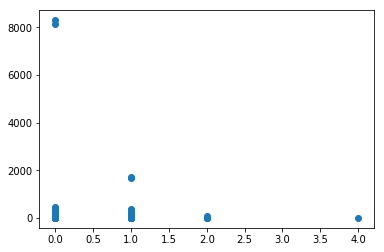

In [15]:
plt.scatter(targets, statistics)

In [19]:
np.mean(targets[statistics > 0])

0.5735294117647058

In [20]:
np.mean(targets)

0.5402298850574713

In [17]:
len(targets)

87

In [ ]:
def get_positions(bandit, pool, verbose=False):
    positions = []
    for i, item in enumerate(pool_iterator(pool)):
        if verbose:
            if i % 5000 == 0:
                print(" {} %".format(round(400 * i / n_objects)))
        query = tuple(map(int, item["query"].split()))
        positions.append(bandit.get_action(query))
    return np.array(positions)

In [ ]:
answer = get_positions(big_bandit, test_pool, verbose=True)
metric = calculate_metric(
    answer, positions_test, targets_test, probas_test
)

In [ ]:
print('', metric, Counter(answer))